# Lognormal test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering a fraction of the sky defined by intervals in $\cos\theta$ and $\phi$ with small "veto" regions.

See the [lognormal catalog notebook](lognormal_catalog.ipynb) for more details of the mock catalog and the cells below for the mask.

(This notebook does a smaller version of the example shown in the paper, which was run on a dedicated compute node rather than a shared notebook server.  The current settings are reasonable for the JAX implementation, but smaller problem sizes will lead to more "real-time" execution in the Python/numpy version.)

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt

In [4]:
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution

env: JAX_ENABLE_X64=True


In [5]:
# Get a random number generator.
seed = None
rng  = np.random.default_rng(seed)

## Generate a mock catalog and randoms

We start by generating two points sets: the data catalog (from a lognormal model) and the random catalog that implicitly defines the mask, the window function, etc.

In [7]:
# Define our footprint by intervals in cos(theta) and phi.
cthta_min = -0.4
cthta_max =  0.5
theta_min =  np.arccos(cthta_max)
theta_max =  np.arccos(cthta_min)
phi_min   =  0.2
phi_max   =  5.0
#
print("Sky fraction {:f}".format( (phi_max-phi_min)*(cthta_max-cthta_min)/(4*np.pi) ))

Sky fraction 0.343775


In [8]:
# To put more structure in the mask, let's "cut out" various pieces of the
# sky, vetoing both data and random points.
# Generate a random catalog of "veto centers" and "radii".
nveto = 10
tveto = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nveto) )
pveto = rng.uniform(low=phi_min,high=phi_max,size=nveto)
rveto = np.ones_like(tveto) * 0.999
# and convert these into 3D unit vectors
nveto = np.zeros( (nveto,3) )
nveto[:,0] = np.sin(tveto)*np.cos(pveto)
nveto[:,1] = np.sin(tveto)*np.sin(pveto)
nveto[:,2] = np.cos(tveto)

In [9]:
def veto_points(tt,pp,wt,nveto,rveto):
    """Returns 'trimmed' tt, pp, wt arrays vetoed by a set of 'veto' points."""
    nh      = np.zeros( (tt.size,3) )
    nh[:,0] = np.sin(tt)*np.cos(pp)
    nh[:,1] = np.sin(tt)*np.sin(pp)
    nh[:,2] = np.cos(tt)
    ww      = np.ones(tt.size,dtype='bool')
    for i in range(nveto.shape[0]):
        ww &= np.dot(nh,nveto[i,:])<rveto[i]
    return( (tt[ww],pp[ww],wt[ww]) )

In [10]:
# Generate a lognormal mock
npnt_fullsky = 3 * 500000
#
# Initialize a helper object from which to draw realizations
nside_mockmaking = 8192 # As large as possible.
Mocks_obj = LogNormalMocks(npnt_fullsky,nside=nside_mockmaking, 
                           theta_range=[theta_min,theta_max],
                           phi_range=[phi_min,phi_max])
#
print('Npnt/Npix=', npnt_fullsky/hp.nside2npix(nside_mockmaking))
cl_theory = Mocks_obj.get_theory_Cl(lmax_out=1000,gauss_order=3000)
# Draw a realization, specifying the random seed if you want
tdata,pdata,wdata = Mocks_obj(seed=0)
#
ndata = len(tdata)
print("Kept {:d} objects in cut.".format(ndata))

Npnt/Npix= 0.001862645149230957
gmap in range (-3.979337e+00,3.798165e+00)
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 4.447854e-05, maxprob=1.984597e-03
Kept 525800 objects in cut.


In [11]:
# Code to generate a random catalog.
def generate_randoms(nrand):
    """Generate nrand randoms in our footprint."""
    trand = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nrand) )
    prand = rng.uniform(low=phi_min,high=phi_max,size=nrand)
    wrand = np.ones_like(trand) * float(ndata)/float(nrand)
    return( (trand,prand,wrand) )

In [12]:
# Generate the randoms.
nrand = 30*ndata
trand,prand,wrand = generate_randoms(nrand)

In [13]:
# Run the data and randoms through the "veto mask".
tdata,pdata,wdata = veto_points(tdata,pdata,wdata,nveto,rveto)
trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
# Correct for the veto'd points.
ndata  = len(tdata)
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)

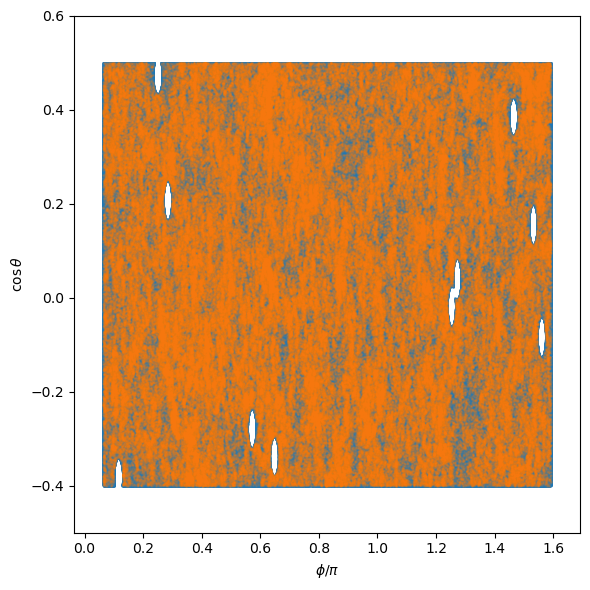

In [14]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(prand/np.pi,np.cos(trand),s=1,c='C0',alpha=0.1,label='Rand',rasterized=True)
ax.scatter(pdata/np.pi,np.cos(tdata),s=1,c='C1',alpha=0.1,label='Data',rasterized=True)
#
ax.set_xlim(phi_min/np.pi-0.1,phi_max/np.pi+0.1)
ax.set_ylim(cthta_min-0.1,cthta_max+0.1)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()

## Harmonic analysis

First do a "direct harmonic analysis" of the data and random points by applying the SHT, differencing, and then computing the psuedo-spectrum.  We will start by finding the window function from the randoms ...

In [20]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [17]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl) - sn

Sorting & digitizing took  1.9092135429382324  seconds.
Reshaping took  1.0172405242919922  seconds.
Precomputing vs took  1.5272061824798584  seconds.
Computing alm's took  1.5007143020629883  seconds.
Sorting & digitizing took  1.550065040588379  seconds.
Reshaping took  0.7534189224243164  seconds.
Precomputing vs took  1.252732515335083  seconds.
Computing alm's took  1.4707233905792236  seconds.


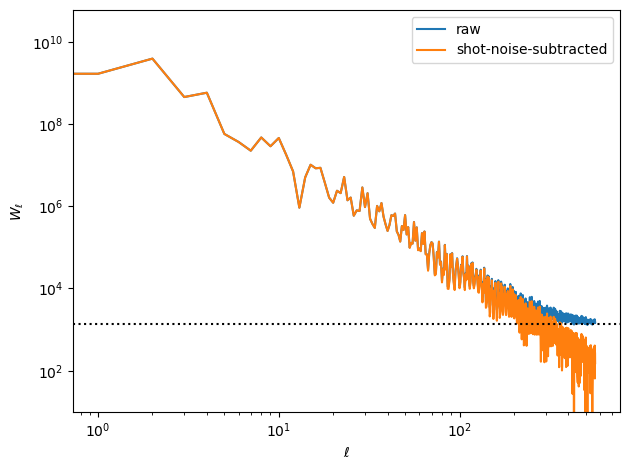

In [18]:
plt.loglog(wl+sn,label='raw')
plt.loglog(wl   ,label='shot-noise-subtracted')
plt.axhline(sn,ls=':',color='k')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
#plt.savefig('harmonic_window.pdf')

In [19]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 2min 34s, sys: 899 ms, total: 2min 35s
Wall time: 2min 38s

Row sums of Mbl:
[1.00004909 1.00003539 1.00004399 1.00004403 1.00005097 1.00005714
 1.0000653  1.00007898 1.00008845 1.00011667 1.00013761 1.00020073
 1.00026012 1.00044177 1.00072231 1.00114209 1.03428518]


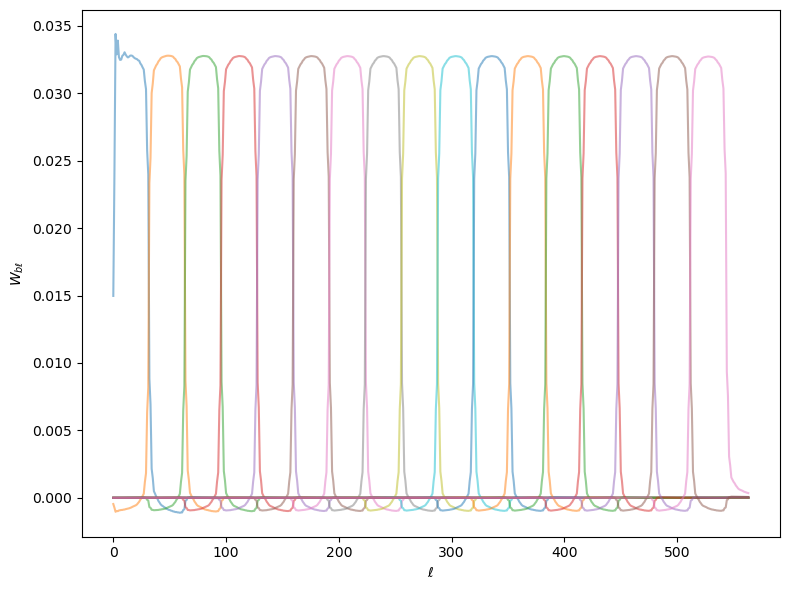

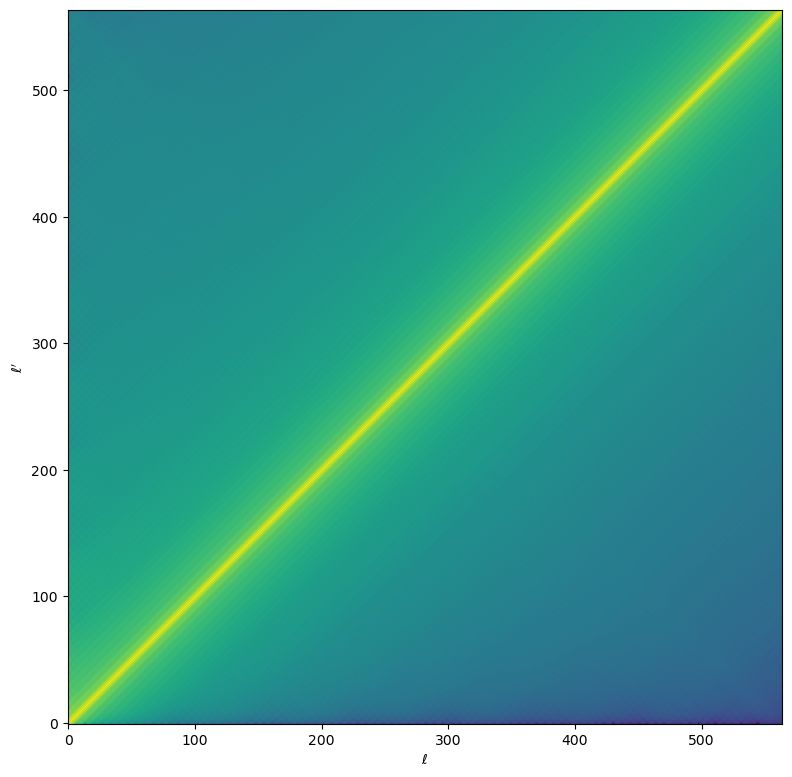

In [20]:
# Plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('harmonic_wbl.pdf')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1,figsize=(8,8))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
#plt.savefig('harmonic_mll.pdf')

Sorting & digitizing took  0.3686032295227051  seconds.
Reshaping took  0.3802769184112549  seconds.
Precomputing vs took  0.8051371574401855  seconds.
Computing alm's took  0.9913883209228516  seconds.
Sorting & digitizing took  0.36313843727111816  seconds.
Reshaping took  0.3730432987213135  seconds.
Precomputing vs took  0.7822105884552002  seconds.
Computing alm's took  0.9310448169708252  seconds.
Sorting & digitizing took  1.4811732769012451  seconds.
Reshaping took  0.42327165603637695  seconds.
Precomputing vs took  0.6855370998382568  seconds.
Computing alm's took  0.9409990310668945  seconds.
Sorting & digitizing took  1.1515922546386719  seconds.
Reshaping took  0.3434872627258301  seconds.
Precomputing vs took  0.604426383972168  seconds.
Computing alm's took  0.9005491733551025  seconds.
hatC in range [6.859649e+04,3.186879e+07]


Text(0, 0.5, '$\\hat{C}_\\ell$')

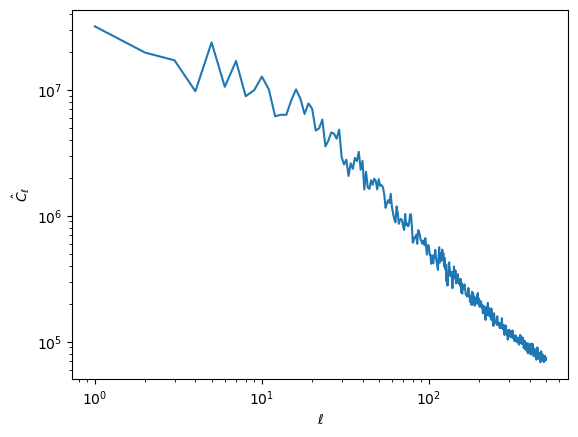

In [21]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [22]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [23]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[1.53650547e-04 9.25997302e-05 6.39488782e-05 4.59423625e-05
 3.88066342e-05 3.16446601e-05 2.69375055e-05 2.34419009e-05
 2.08200100e-05 1.97644132e-05 1.74528382e-05 1.65731552e-05
 1.54312252e-05]


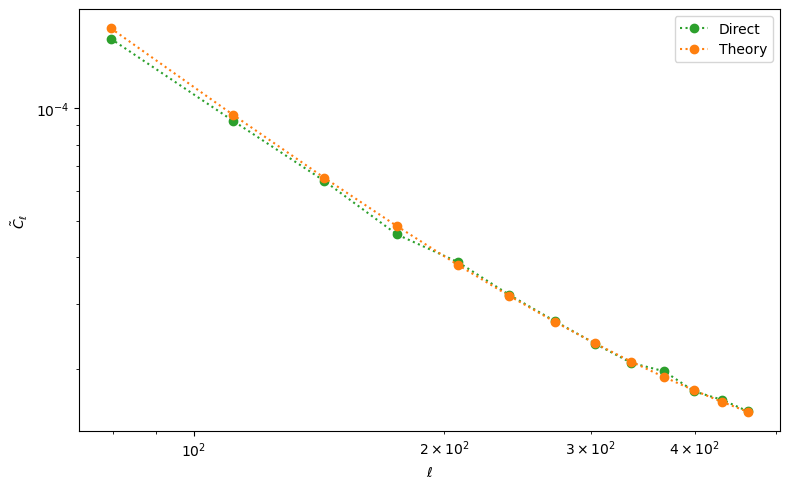

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [21]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = hp.nside2npix(nside)
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

We don't have enough randoms to get a good outcome with a pixel-based analysis, so let's generate more.

In [22]:
# Generate the randoms.
nrand = 70*ndata
trand2,prand2,wrand2 = generate_randoms(nrand)
# Run the data and randoms through the "veto mask".
trand2,prand2,wrand2 = veto_points(trand2,prand2,wrand2,nveto,rveto)
# Append the new randoms to the end of the old randoms.
trand  = np.append(trand,trand2)
prand  = np.append(prand,prand2)
wrand  = np.append(wrand,wrand2)
# Redo the weights.
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)

dmap.sum= 32434325379.379616
rmap.sum= 32434325379.368603
fsky= 0.3385607401529948


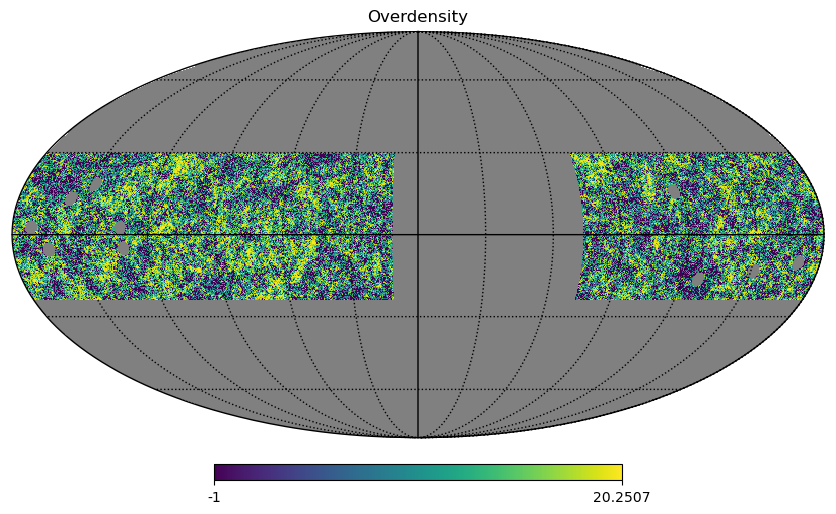

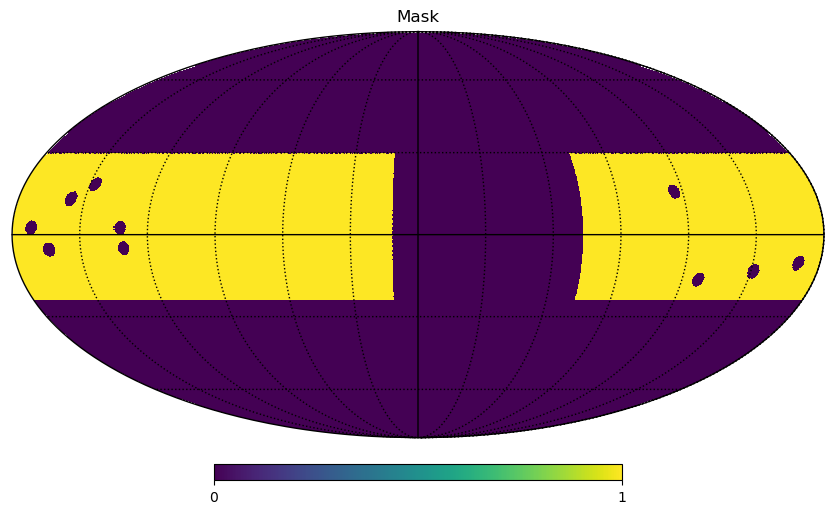

In [23]:
# Show an example at some nside.
nside= 256
npix = hp.nside2npix(nside)
dmap = make_map(tdata,pdata,wdata,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
#
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
omap      = np.zeros(npix,dtype='f8')
omap[msk] = dmap[msk]/rmap[msk]
omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
mask      = np.zeros(npix)
mask[msk] = 1.0
#
fsky = len(msk)/float(len(mask))
print("fsky=",fsky)
#
ma = hp.ma(omap)
ma.mask = (mask<0.5)
hp.mollview(ma,norm='hist',title='Overdensity')
hp.graticule()
plt.savefig('overdensity.pdf')
#
hp.mollview(mask,title='Mask')
hp.graticule()

Text(0, 0.5, '$\\hat{C}_\\ell$')

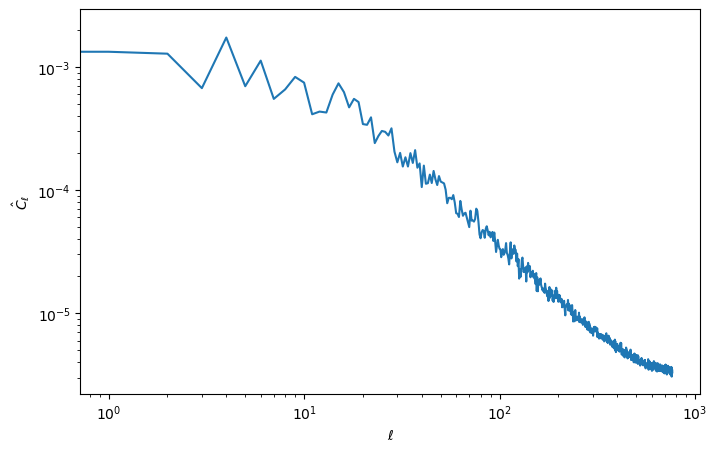

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
#
cl_via_map = hp.anafast(omap)
ax.loglog(cl_via_map[1:-1])
#
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')

In [25]:
# Measure the W_l
wl_maplevel = hp.anafast(mask)

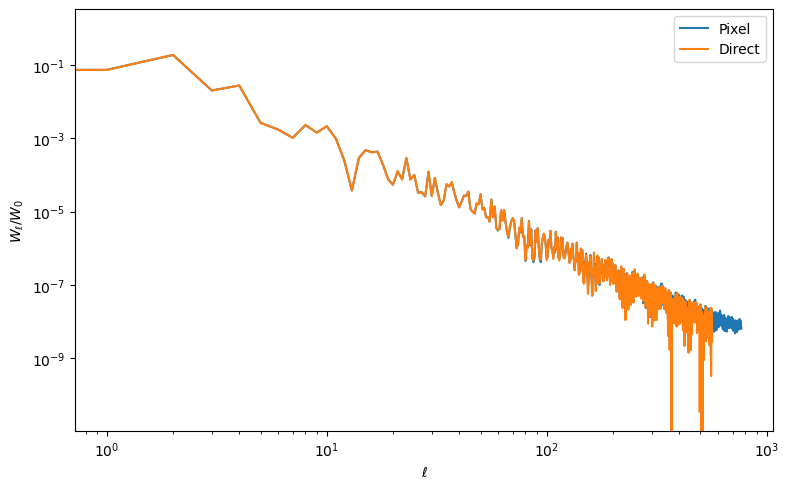

In [26]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.loglog(wl_maplevel/wl_maplevel[0],label='Pixel')
ax.loglog(wl/wl[0],label='Direct')
#
ax.legend()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_\ell/W_0$')
#
plt.tight_layout()

In [27]:
# We will initialize a different mode-decoupling object
# because our map-level mask has a different normalization
# (of course we could just renormalize...)
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)
#
# Deconvolve the mask to produce a "map delta" estimate of tilde{C}_ell.
binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard], mdel_decoupled[Ndiscard:-Ndiscard]

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


Text(0, 0.5, '$\\hat{C}_\\ell$')

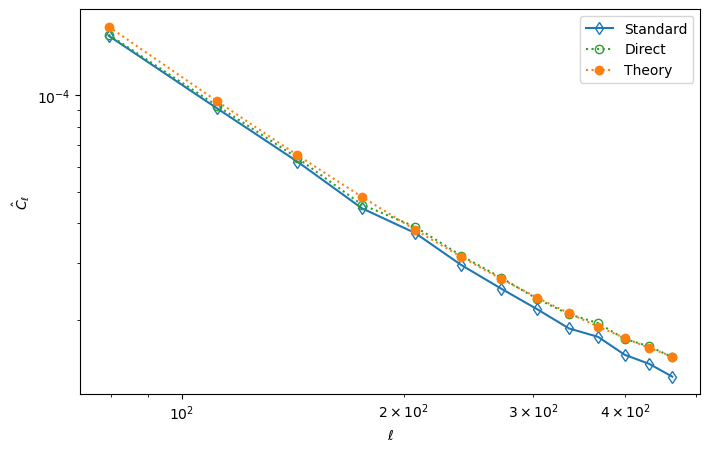

In [28]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,mdel_decoupled,'d-',color='C0',\
        mfc='None',label='Standard')
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',\
        mfc='None',label='Direct')
#
# Compare to the theory convolved with the bandpower window function.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells,clt_conv[Ndiscard:-Ndiscard],'o:',\
        color='C1',label='Theory')
#
ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')

# Compare to the standard analysis as a function of Nside

Now we can compare the direct SHT approach to the standard one, varying the number of pixels in the "map based" analysis.

In [29]:
# Let's save ourselves some time by using the same W_l irrespective of the number of randoms.
# Another option would be to recompute this at the relevant Nside for consistency with how a
# pixel-based analysis would likely be performed.
nside = 512
npix  = hp.nside2npix(nside)
rmap  = make_map(trand,prand,wrand,nside)
#
# Make a binary mask.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
mask      = np.zeros(npix)
mask[msk] = 1.0
# Measure the W_l and trim it to the same size as our direct W_l.
wl_maplevel = hp.anafast(mask)
wl_maplevel = wl_maplevel[:wl.size]

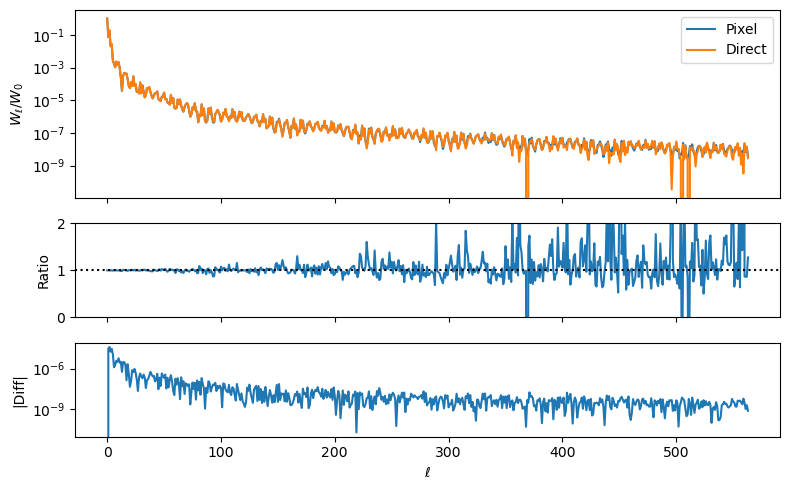

In [30]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(3,1,sharex=True,figsize=(8,5),\
                      gridspec_kw={'height_ratios':[2,1,1]})
#
ells = np.arange(wl_maplevel.size)
ax[0].plot(ells,wl_maplevel/wl_maplevel[0],label='Pixel')
ax[0].plot(ells,wl/wl[0],label='Direct')
#
ax[1].plot(ells,(wl_maplevel/wl_maplevel[0])/(wl/wl[0]))
ax[1].axhline(1.0,ls=':',color='k')
#
error = np.abs( wl_maplevel/wl_maplevel[0] - wl/wl[0] )
ax[2].plot(ells,error)
#
ax[0].legend()
ax[0].set_yscale('log')
ax[2].set_yscale('log')
ax[1].set_ylim(0,2)
ax[2].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$W_\ell/W_0$')
ax[1].set_ylabel(r'Ratio')
ax[2].set_ylabel(r'|Diff|')
#
plt.tight_layout()
#plt.savefig('compare_window.pdf')

In [31]:
# Make a mode-decoupling object to go with the mask.
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


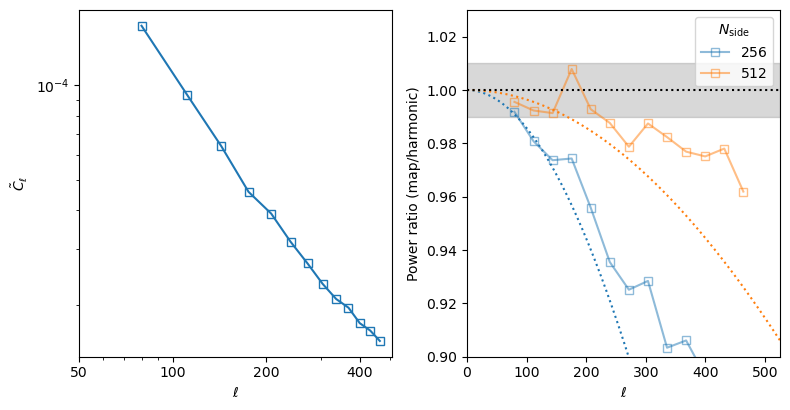

In [32]:
fig,ax = plt.subplots(1,2,sharey=False,figsize=(8,4.2))
#
xticks = [50,100,200,400]
ax[0].plot(binned_ells,hdif_decoupled,'s-',mfc='None')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks,[str(x) for x in xticks])
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\tilde{C}_\ell$')
#
icol= 0
for nside in [256,512]:
    npix = hp.nside2npix(nside)
    dmap = make_map(tdata,pdata,wdata,nside)
    rmap = make_map(trand,prand,wrand,nside)
    #
    msk = np.nonzero(rmap>0)[0]
    avg = np.mean(rmap[msk])
    msk = np.nonzero(rmap>0.5*avg)[0]
    #
    omap      = np.zeros(npix,dtype='f8')
    omap[msk] = dmap[msk]/rmap[msk]
    omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
    mask      = np.zeros(npix)
    mask[msk] = 1.0
    #   
    cl_via_map= hp.anafast(omap)
    #
    # Deconvolve the mask
    binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
    binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard],mdel_decoupled[Ndiscard:-Ndiscard]
    #
    ratio= mdel_decoupled/hdif_decoupled
    pixwn= hp.pixwin(nside)
    #
    ax[1].plot(binned_ells,ratio,'s-',color='C'+str(icol),alpha=0.5,\
               mfc='None',label='${:4d}$'.format(nside))
    ax[1].plot(np.arange(pixwn.size),pixwn**2,ls=':',color='C'+str(icol))
    icol = (icol+1)%10
#   
ax[1].axhline(1.0,ls=':',color='k')
ax[1].fill_between([0,Nl+25],[0.99,0.99],[1.01,1.01],color='grey',alpha=0.3)
ax[1].set_ylabel(r'Power ratio (map/harmonic)')
ax[1].legend(title=r'$N_{\rm side}$')
ax[1].set_ylim(0.90,1.03)
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlim([0,Nl+25])
#
plt.tight_layout()
#plt.savefig('compare_pipelines.pdf')

Note that the exact behavior of the ratio depends upon the number of points and the geometry, since e.g. we should get the right answer either way in the shot-noise dominated regime.

# The End